# Demo 1: Create new project and import data

In [ ]:
# Import packages

# Pour effectuer des requêtes HTTP
import requests

# Pour la visualisation
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap


import contextily as cx

# Pour manipuler des données géospatiales
import geopandas as gpd
from shapely.geometry import Polygon, box


# Pour récupérer des données OpenStreetMap
import osmnx as ox

As a convetion in Python, we start by defining the key variables used throughout the notebook.

- open access data : url path with direct link to data download (here, "url");
- filepaths for data downloaded from online source (here, "shp_zip_filepath" and "data_filepath") - note that in this example the original data is downloaded in a zip file;
- area of interest (AOI) : define the geographic scope of the analysis - see explanations given in step 4 below.

In [ ]:
# Online data source
url = "https://datacatalogfiles.worldbank.org/ddh-published/0038704/DR0048007/eo4sd_saint_louis_lulchr_2006.zip?versionId=2023-01-19T04:13:48.5003077Z"

# Filepaths
shp_zip_filepath = "../data/st-louis-lulchr_2016.zip"
data_filepath = "../data/land_use_gdf_2016.gpkg"

# Area of interest (2 options: manual entry or string request argument)
# manual_aoi = [-16.83, 14.80, -14.58, 16.84] # note: x,y values for EPSG 4326
city_aoi = "Saint Louis Senegal"
CRS_LON_LAT = 4326

## Setup

### Step 1: Download the data

In [ ]:
# Go to URL
response = requests.get(url)

# Dowload data (zip file will be placed in predefined filepath)
with open(shp_zip_filepath, "wb") as f:
    f.write(response.content)

### Step 2: Read the shapefile using GeoPandas

In [ ]:
# Open zip file as geodataframe (using geopandas)
land_use_gdf = gpd.read_file(shp_zip_filepath)

Visualize the data as a table:   

In [ ]:
land_use_gdf.head()

C_L1                            N_L1     C_L2                 N_L2  \
0  30000.0  Natural and Semi-natural Areas  31000.0               Forest   
1  20000.0               Agricultural Area  20000.0    Agricultural area   
2  30000.0  Natural and Semi-natural Areas  33000.0            Bare land   
3  20000.0               Agricultural Area  20000.0    Agricultural area   
4  10000.0             Artificial Surfaces  11000.0  Artificial Surfaces   

      C_L3                 N_L3     C_L4                 N_L4           AREA  \
0  31000.0               Forest  31000.0               Forest   31779.287347   
1  20000.0    Agricultural area  20000.0    Agricultural Land  696975.419414   
2  33000.0            Bare land  33000.0            Bare land   39409.802826   
3  20000.0    Agricultural area  20000.0    Agricultural Land  255418.249018   
4  10000.0  Artificial Surfaces  10000.0  Artificial Surfaces   28146.929138   

   ID                                           geometry  
0   1  POLYGON ((345033.457 1763478.320, 345032.168 1...  
1   2  POLYGON ((345033.457 1763478.320, 344808.508 1...  
2   3  POLYGON ((344641.596 1763526.912, 344632.826 1...  
3   4  POLYGON ((345117.706 1764281.550, 345150.702 1...  
4   5  POLYGON ((344641.596 1763526.912, 344338.653 1...

Plot the data: 

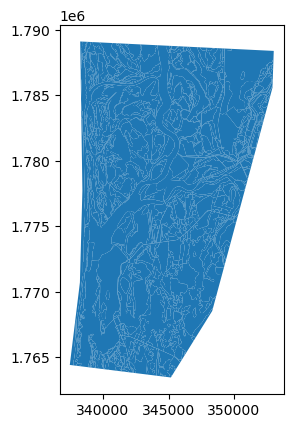

In [ ]:
ax = land_use_gdf.plot()
plt.show()

#### (More on plotting later) 

### Step 3: Make sure your CRS is not empty


es important que no este empty porque si tienes datos de suiza con crs suizo y quieres usar datos de osm que esta en lon lat, necesitas esa info para poder hacer operaciones espaciales, por ejemplo sacar informacion de carreteras dentro de algún limite administrativo... 


In [ ]:
land_use_gdf.crs

<Projected CRS: EPSG:32628>
Name: WGS 84 / UTM zone 28N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 18°W and 12°W, northern hemisphere between equator and 84°N, onshore and offshore. Gambia. Greenland. Guinea. Guinea-Bissau. Iceland. Ireland - offshore Porcupine Basin. Mauritania. Morocco. Senegal. Sierra Leone. Western Sahara.
- bounds: (-18.0, 0.0, -12.0, 84.0)
Coordinate Operation:
- name: UTM zone 28N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

si no tiene crs pero lo sabes you cans et it by hand using 
land_use_gdf.crs = algo 

### Step 4: Define your Area of Interest (AOI)

 In this step, we specify the area of interest (AOI) that we want to focus on in our analysis. 
 The AOI could be a specific region, topic, or aspect of the data that we want to explore further.
 This serves for narrowing down the scope of our analysis and ensuring that we extract meaningful insights.



In [ ]:
# Fetch geographical data for the Area of Interest and convert it into a GeoDataFrame
# Obtain the total bounds (bounding box coordinates) of the GeoDataFrame
ox.geocode_to_gdf(city_aoi).total_bounds

array([-16.5159978,  15.9577436, -16.3964017,  16.084759 ])

We can transform this information into a shapely geometry, in this case a polygon/rectangle.


In [ ]:
# Store the total bounds of the geographical data fetched for the AOI
xmin, ymin, xmax, ymax = ox.geocode_to_gdf(city_aoi).total_bounds

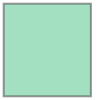

In [ ]:
city_bbox_geom = box(xmin, ymin, xmax, ymax)
city_bbox_geom

To set the CRS we can put this geometry into a geoDataFrame.

NOTE: you need to pass a list, even is there is only one geometry. 

In [ ]:
city_boundary_gdf = gpd.GeoDataFrame(
    geometry=[
        city_bbox_geom
    ],  # Creates a Shapely Polygon representing the bounding box of the city
    crs=CRS_LON_LAT,  # Specifies the Coordinate Reference System (CRS) for the GeoDataFrame
)


Now that we have a geoDataFrame we can better visualize the boundaries.



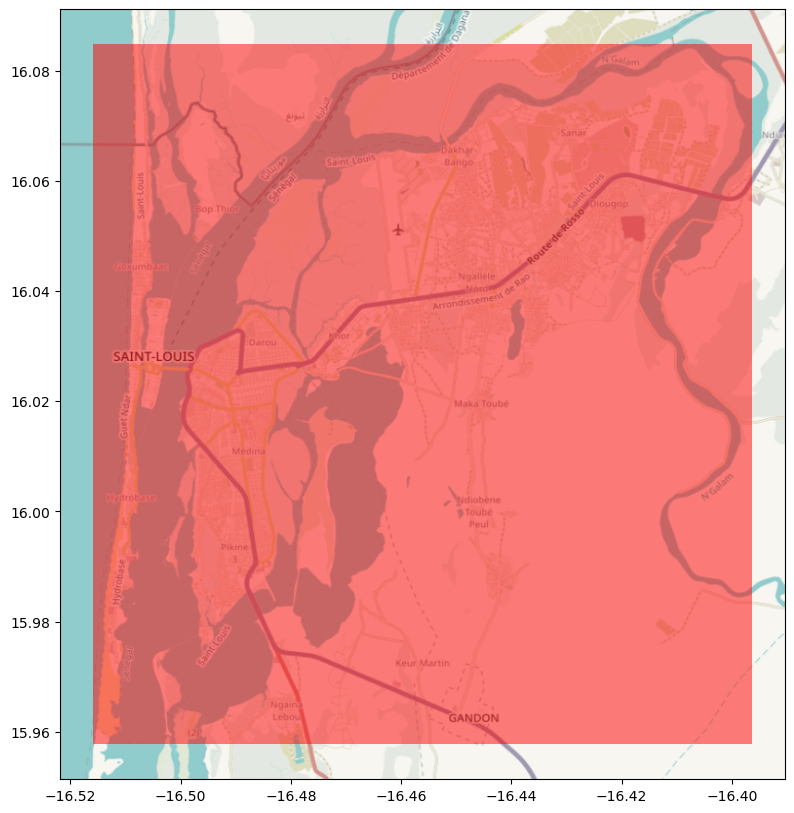

In [ ]:
# Plot the city boundary on a matplotlib Axes object ("ax")
ax = city_boundary_gdf.plot(figsize=(10, 10), alpha=0.5, color="r")
cx.add_basemap(ax, crs=city_boundary_gdf.crs.to_string(), attribution="")

Since we have a CRS, we can reprojected to plot it together with the land use data. 


<Axes: >

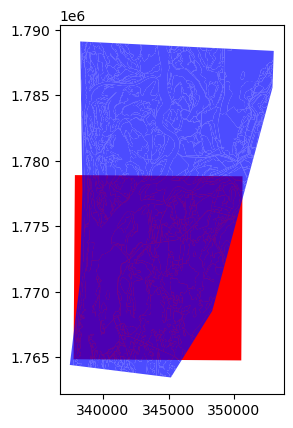

In [ ]:
ax = city_boundary_gdf.to_crs(land_use_gdf.crs).plot(color="r")
land_use_gdf.plot(ax=ax, color="blue", alpha=0.7)

Let us now project our bounding box to the land use crs: 

In [ ]:
# Project the city boundary to the crs od the land use geoDataFrame
proj_city_boundary_gdf = city_boundary_gdf.to_crs(land_use_gdf.crs)
proj_city_boundary_gdf

geometry
0  POLYGON ((350552.784 1764761.975, 350647.332 1...

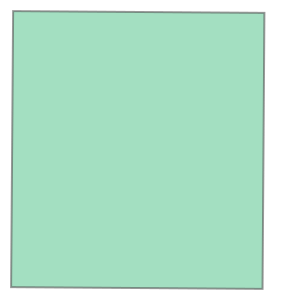

In [ ]:
# Now extract the geometry from the reprojected geoDataFrame
proj_bbox = proj_city_boundary_gdf["geometry"].iloc[0]
proj_bbox

In [ ]:
# We can see which land use polygons intersect with the projected bounding box
land_use_gdf.intersects(proj_bbox)

0      False
1       True
2      False
3      False
4      False
       ...  
763     True
764    False
765     True
766    False
767     True
Length: 768, dtype: bool

In [ ]:
# We can use these boolean list to filter the geoDataFrame.
land_use_gdf[land_use_gdf.intersects(proj_bbox)].head()

C_L1                            N_L1     C_L2                 N_L2  \
1   20000.0               Agricultural Area  20000.0    Agricultural area   
5   30000.0  Natural and Semi-natural Areas  31000.0               Forest   
6   10000.0             Artificial Surfaces  11000.0  Artificial Surfaces   
8   30000.0  Natural and Semi-natural Areas  33000.0            Bare land   
10  10000.0             Artificial Surfaces  11000.0  Artificial Surfaces   

       C_L3                 N_L3     C_L4                 N_L4           AREA  \
1   20000.0    Agricultural area  20000.0    Agricultural Land  696975.419414   
5   31000.0               Forest  31000.0               Forest  440580.530103   
6   10000.0  Artificial Surfaces  10000.0  Artificial Surfaces  761325.315917   
8   33000.0            Bare land  33000.0            Bare land  326408.301566   
10  10000.0  Artificial Surfaces  10000.0  Artificial Surfaces  286636.759528   

    ID                                           geometry  
1    2  POLYGON ((345033.457 1763478.320, 344808.508 1...  
5    6  POLYGON ((345117.706 1764281.550, 345095.669 1...  
6    7  POLYGON ((344260.542 1764444.620, 344317.142 1...  
8    9  POLYGON ((344260.542 1764444.620, 344258.413 1...  
10  11  POLYGON ((347115.071 1775270.311, 347115.071 1...

In [ ]:
# NOTE: that we passed from 768 entries to 418 entries

print("length of dataset: ", len(land_use_gdf))
print(
    "length of filter dataset: ", len(land_use_gdf[land_use_gdf.intersects(proj_bbox)])
)

length of dataset:  768
length of filter dataset:  418


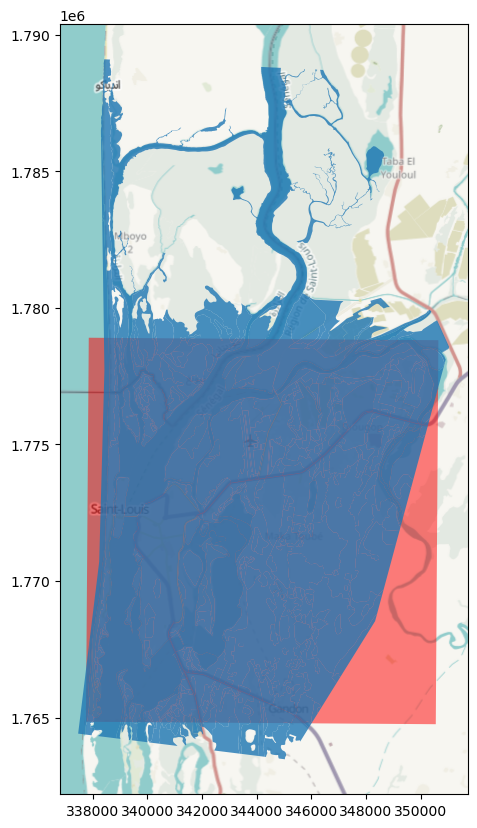

In [ ]:
# Plot the subset of land use data that intersects with the city boundary geometry
ax = proj_city_boundary_gdf.plot(figsize=(10, 10), color="r", alpha=0.5)
land_use_gdf[land_use_gdf.intersects(proj_bbox)].plot(ax=ax, alpha=0.8)
cx.add_basemap(ax, crs=land_use_gdf.crs.to_string(), attribution="")

FYI, there are other ways to filter data, the function that you decide to use depends on the subject of interest. 
As an example, we can filter with intersection 

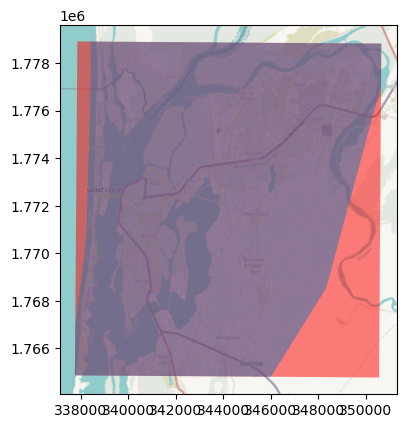

In [ ]:
ax = proj_city_boundary_gdf.plot(figsize=(10, 10), color="r", alpha=0.5)
land_use_gdf.intersection(proj_bbox).plot(ax=ax, figsize=(10, 10), alpha=0.5)
cx.add_basemap(
    ax,
    crs=land_use_gdf.crs.to_string(),
    attribution="",
)

In [ ]:
# Filter the data and create a new gdf
stlouis_land_use_gdf = land_use_gdf[land_use_gdf.intersects(proj_bbox)]

### Step 5: Save your data so you can use it later on. 
We will be using GeoPackage
But you can also use GEOJSON
```land_use_gdf.to_file('data_filepath.geojson')```

For more info about shapefile alternative : [switchfromshapefile.org](http://switchfromshapefile.org/#geopackage)


In [ ]:
stlouis_land_use_gdf.to_file(data_filepath)

## 2. Visualize the data

In [ ]:
stlouis_land_use_gdf.head(3)

C_L1                            N_L1     C_L2                 N_L2  \
1  20000.0               Agricultural Area  20000.0    Agricultural area   
5  30000.0  Natural and Semi-natural Areas  31000.0               Forest   
6  10000.0             Artificial Surfaces  11000.0  Artificial Surfaces   

      C_L3                 N_L3     C_L4                 N_L4           AREA  \
1  20000.0    Agricultural area  20000.0    Agricultural Land  696975.419414   
5  31000.0               Forest  31000.0               Forest  440580.530103   
6  10000.0  Artificial Surfaces  10000.0  Artificial Surfaces  761325.315917   

   ID                                           geometry  
1   2  POLYGON ((345033.457 1763478.320, 344808.508 1...  
5   6  POLYGON ((345117.706 1764281.550, 345095.669 1...  
6   7  POLYGON ((344260.542 1764444.620, 344317.142 1...

### 2.1 Plot and Edit your Data 

1. Add contextual information
- Use "contextily" as cx tu add geographic context to the plot.
- NOTE: You can only use contectily is you have the CRS of your data

Refer to : [Contextily](https://contextily.readthedocs.io/en/latest/) 
 

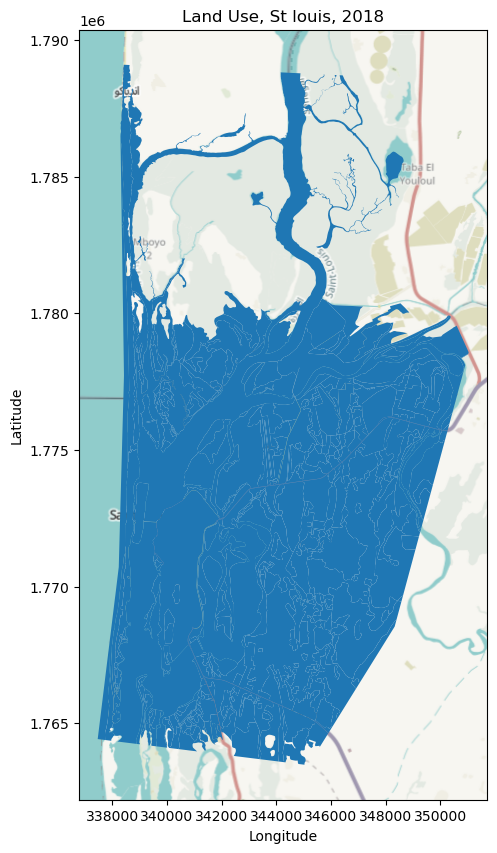

In [ ]:
ax = stlouis_land_use_gdf.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stlouis_land_use_gdf.crs.to_string(), attribution="")
plt.title("Land Use, St louis, 2018")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

- Use ".explore" to generate an interactive map based on GeoPandas and leaflet.js

Refer to : [explore()](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html)


In [ ]:
stlouis_land_use_gdf.explore()

### 2.2 Identify and Visualize your attributs
####  Visualize the target attribut
    

In [ ]:
# Chose the column with the attributs you'd like to visualize
# For instance:
stlouis_land_use_gdf["N_L1"].unique()

array(['Agricultural Area', 'Natural and Semi-natural Areas',
       'Artificial Surfaces', 'Water', 'Wetlands'], dtype=object)

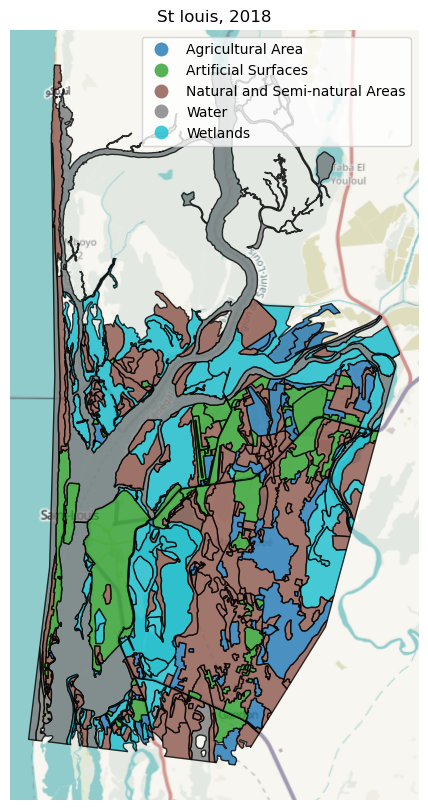

In [ ]:
# Plot the attributs
ax = stlouis_land_use_gdf.plot(
    column="N_L1",
    categorical=True,
    legend=True,
    figsize=(10, 10),
    edgecolor="k",
    alpha=0.8,
)
cx.add_basemap(ax, crs=stlouis_land_use_gdf.crs.to_string(), attribution="")
ax.set_axis_off()
plt.title("St louis, 2018")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
stlouis_land_use_gdf.explore(
    column="N_L1",
    tooltip="N_L1",  # show the N_L1 value in tooltip (on hover)
    popup=True,  # show all values in popup (on click)
    tiles="CartoDB positron",  # use "CartoDB positron" tiles
    cmap="Set1",  # use "Set1" matplotlib colormap
    style_kwds=dict(color="black"),  # use black outline
)

#### Change colors 

Refer to [Color maps](https://matplotlib.org/stable/users/explain/colors/colormaps.html)
    

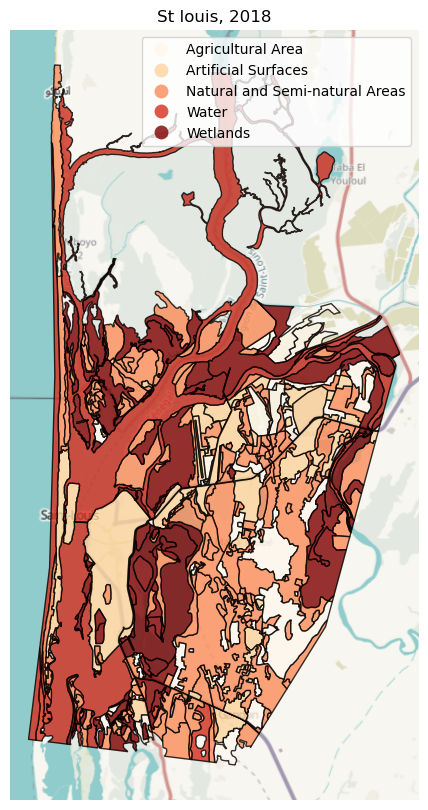

In [ ]:
# Plot the attribits
ax = stlouis_land_use_gdf.plot(
    column="N_L1",
    categorical=True,
    legend=True,
    figsize=(10, 10),
    edgecolor="k",
    cmap="OrRd",
    alpha=0.8,
)
cx.add_basemap(ax, crs=stlouis_land_use_gdf.crs.to_string(), attribution="")
ax.set_axis_off()
plt.title("St louis, 2018")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

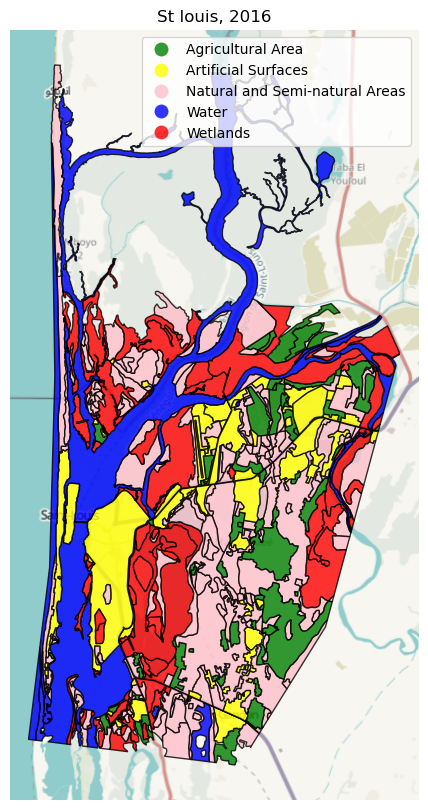

In [ ]:
# Define color map
colors = ["green", "yellow", "pink", "blue", "red"]  # Assign colors to attributes
cmap = ListedColormap(colors)

# Plot the attributes
ax = stlouis_land_use_gdf.plot(
    column="N_L1",
    categorical=True,
    legend=True,
    figsize=(10, 10),
    edgecolor="k",
    alpha=0.8,
    cmap=cmap,
)
cx.add_basemap(ax, crs=stlouis_land_use_gdf.crs.to_string(), attribution="")
ax.set_axis_off()
plt.title("St louis, 2016")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

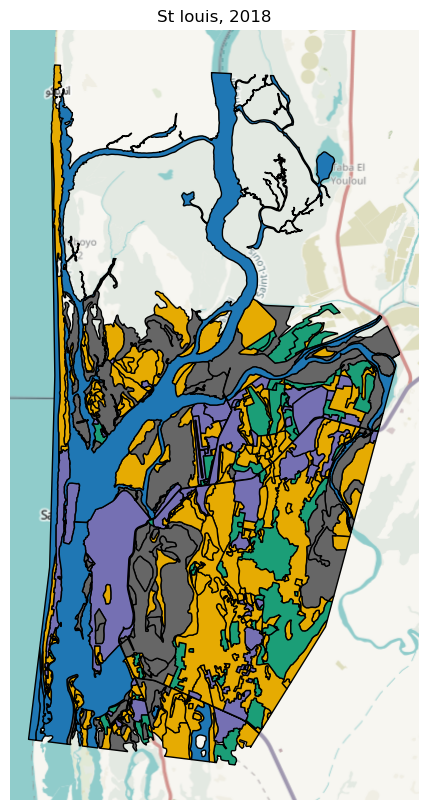

In [ ]:
# Plot water separately in blue
ax = stlouis_land_use_gdf[stlouis_land_use_gdf["N_L1"] != "Water"].plot(
    column="N_L1", categorical=True, cmap="Dark2", figsize=(10, 10), edgecolor="k"
)
stlouis_land_use_gdf[stlouis_land_use_gdf["N_L1"] == "Water"].plot(
    column="N_L1", ax=ax, edgecolor="k"
)
cx.add_basemap(ax, crs=stlouis_land_use_gdf.crs.to_string(), attribution="")
ax.set_axis_off()
plt.title("St louis, 2016")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

#### Change the target 
    

In [ ]:
# list of argumnts
stlouis_land_use_gdf["N_L1"].unique()

array(['Agricultural Area', 'Natural and Semi-natural Areas',
       'Artificial Surfaces', 'Water', 'Wetlands'], dtype=object)

In [ ]:
# Select one attribut
stlouis_land_use_gdf[stlouis_land_use_gdf["N_L1"] == "Artificial Surfaces"].head()

C_L1                 N_L1     C_L2                 N_L2     C_L3  \
6   10000.0  Artificial Surfaces  11000.0  Artificial Surfaces  10000.0   
10  10000.0  Artificial Surfaces  11000.0  Artificial Surfaces  10000.0   
15  10000.0  Artificial Surfaces  11000.0  Artificial Surfaces  10000.0   
26  10000.0  Artificial Surfaces  11000.0  Artificial Surfaces  10000.0   
27  10000.0  Artificial Surfaces  11000.0  Artificial Surfaces  10000.0   

                   N_L3     C_L4                 N_L4           AREA  ID  \
6   Artificial Surfaces  10000.0  Artificial Surfaces  761325.315917   7   
10  Artificial Surfaces  10000.0  Artificial Surfaces  286636.759528  11   
15  Artificial Surfaces  10000.0  Artificial Surfaces  520950.931733  16   
26  Artificial Surfaces  10000.0  Artificial Surfaces   85681.801606  27   
27  Artificial Surfaces  10000.0  Artificial Surfaces  102880.941809  28   

                                             geometry  
6   POLYGON ((344260.542 1764444.620, 344317.142 1...  
10  POLYGON ((347115.071 1775270.311, 347115.071 1...  
15  POLYGON ((345199.544 1766102.618, 345173.591 1...  
26  POLYGON ((343728.037 1765845.383, 343710.880 1...  
27  POLYGON ((343912.269 1766783.067, 344016.132 1...

In [ ]:
# Explore or plot that attribut
stlouis_land_use_gdf[land_use_gdf["N_L1"] == "Artificial Surfaces"].explore()

/Users/martibosch/mambaforge/envs/planification_urbaine_sud/lib/python3.11/site-packages/geopandas/geodataframe.py:1456: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


#### Target more than one attribut 

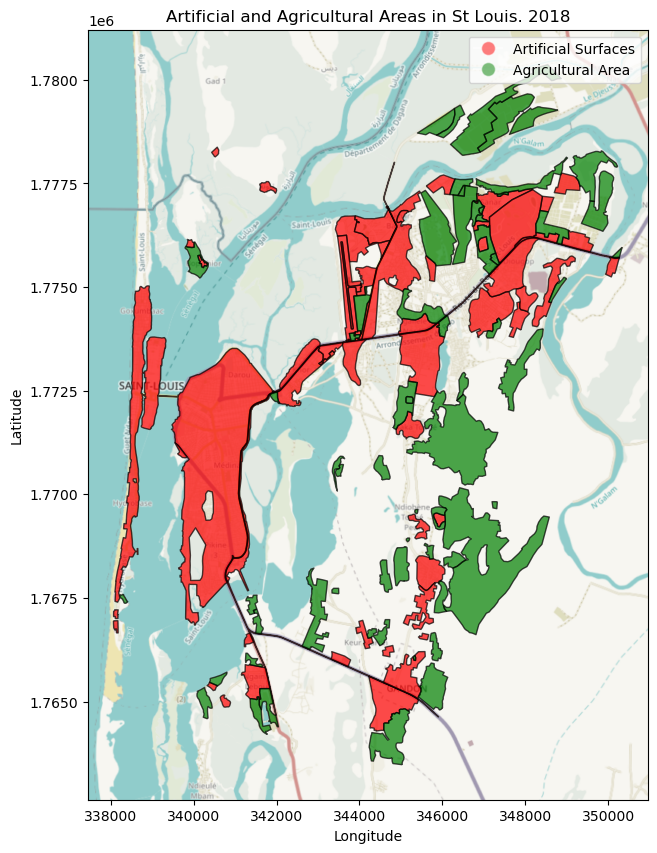

In [ ]:
# Select several attributs and plot them
artificial_surfaces = stlouis_land_use_gdf[
    stlouis_land_use_gdf["N_L1"] == "Artificial Surfaces"
]
agricultural_area = stlouis_land_use_gdf[
    stlouis_land_use_gdf["N_L1"] == "Agricultural Area"
]


# Plot the map with different colors for each land use type
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Informal Settlement in red
artificial_surfaces.plot(ax=ax, color="red", edgecolor="black", alpha=0.7)

# Plot Planned Residential in blue
agricultural_area.plot(ax=ax, color="green", edgecolor="black", alpha=0.7)

# Create custom legend handles
legend_handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="red",
        markersize=10,
        label="Artificial Surfaces",
        alpha=0.5,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="green",
        markersize=10,
        label="Agricultural Area",
        alpha=0.5,
    ),
]

# Add basemap using Contextily
cx.add_basemap(ax, crs=stlouis_land_use_gdf.crs.to_string(), attribution="")

# Add legend with custom handles
ax.legend(handles=legend_handles)

plt.title("Artificial and Agricultural Areas in St Louis. 2018")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Save plot to PDF
plt.savefig("Artificial_Agricultural_st-Louis_2018.pdf", bbox_inches="tight")

plt.show()